# DIGGS Fundamentals: Parsing Geotechnical Data

Welcome to this tutorial on working with **DIGGS** (Data Interchange for Geotechnical and Geoenvironmental Specialists) files!

## Before You Start: Select the Correct Kernel

**Important:** Before running any code cells, you must select the correct Python kernel:

1. Click on the kernel selector in the top-right corner of this notebook (it may say "Python 3.13.5" or similar)
2. Select **"DIGGS Hackathon (Python 3.11)"** from the dropdown list
3. Wait for the kernel to connect

This kernel has all the required packages (pandas, lxml, matplotlib, etc.) pre-installed.

---

## What is DIGGS?

DIGGS is an XML-based data transfer standard developed by the geotechnical community. It allows engineers and scientists to share subsurface data in a standardized format. Think of it as a common language for geotechnical data.

### What kind of data does DIGGS contain?

- **Project Information**: Project name, client, location, dates
- **Boreholes**: Drill hole locations, depths, and construction details
- **Soundings**: CPT (Cone Penetration Test) data
- **Samples**: Soil samples collected during drilling
- **Tests**: Laboratory and field test results (SPT, grain size, etc.)

## What You'll Learn

By the end of this notebook, you'll be able to:
1. Load and parse DIGGS XML files
2. Extract project, borehole, and test data
3. Convert DIGGS data to pandas DataFrames
4. Create simple visualizations of geotechnical data

Let's get started!

## 1. Setup: Import Required Libraries

We'll use three main libraries:
- **lxml**: For parsing XML with namespace support
- **pandas**: For organizing data into tables
- **matplotlib**: For creating visualizations

In [1]:
# Import the libraries we need
from lxml import etree
import pandas as pd
import matplotlib.pyplot as plt

# Make our plots look nice (use a style that works across matplotlib versions)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    try:
        plt.style.use('seaborn-whitegrid')
    except:
        pass  # Use default style if seaborn styles not available

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Loading a DIGGS File

DIGGS files are XML documents. We'll use `lxml` to parse them because it handles **namespaces** well.

### What are namespaces?
XML namespaces prevent naming conflicts. DIGGS uses several namespaces:
- `diggs:` - DIGGS-specific elements (boreholes, tests, etc.)
- `gml:` - Geographic Markup Language (locations, coordinates)
- `xlink:` - Cross-references between elements

In [2]:
# Path to our DIGGS file
diggs_file = '../data/Diggs_small.xml'

# Parse the XML file
tree = etree.parse(diggs_file)
root = tree.getroot()

print(f"Successfully loaded: {diggs_file}")
print(f"Root element: {root.tag}")

Successfully loaded: ../data/Diggs_small.xml
Root element: {http://diggsml.org/schema-dev}Diggs


### Define the Namespaces

To query elements in a DIGGS file, we need to define the namespaces. These are found in the root element of the XML file.

In [3]:
# Define namespaces used in this DIGGS file
# You can find these in the root element's xmlns attributes
namespaces = {
    'diggs': 'http://diggsml.org/schema-dev',
    'gml': 'http://www.opengis.net/gml/3.2',
    'xlink': 'http://www.w3.org/1999/xlink',
    'glr': 'http://www.opengis.net/gml/3.3/lr'
}

print("Namespaces defined!")
print("\nThese allow us to query elements like:")
print("  - diggs:Borehole")
print("  - gml:name")
print("  - gml:pos (for coordinates)")

Namespaces defined!

These allow us to query elements like:
  - diggs:Borehole
  - gml:name
  - gml:pos (for coordinates)


## 3. Understanding the DIGGS Structure

Let's explore what's in our DIGGS file. A typical DIGGS file contains:
- `documentInformation`: Metadata about the file itself
- `project`: Project details
- `samplingFeature`: Boreholes and soundings
- `samplingActivity`: Sample collection records
- `measurement`: Test results

In [4]:
# Let's see what top-level elements are in the file
print("Top-level elements in this DIGGS file:\n")

# Count occurrences of each element type
element_counts = {}
for child in root:
    # Remove namespace prefix for cleaner display
    tag_name = child.tag.split('}')[-1] if '}' in child.tag else child.tag
    element_counts[tag_name] = element_counts.get(tag_name, 0) + 1

for element, count in element_counts.items():
    print(f"  {element}: {count}")

Top-level elements in this DIGGS file:

  documentInformation: 1
  project: 1
  samplingFeature: 68
  samplingActivity: 721
  sample: 707
  observation: 20
  measurement: 2088


## 4. Extracting Project Information

Let's start by getting basic information about the project.

In [5]:
# Find the Project element
# Note: We use .// to search anywhere in the tree
project = root.find('.//diggs:Project', namespaces)

if project is not None:
    # Get project name
    name = project.find('gml:name', namespaces)
    project_name = name.text if name is not None else "Unknown"
    
    # Get project description
    desc = project.find('gml:description', namespaces)
    project_desc = desc.text if desc is not None else "No description"
    
    print("=" * 50)
    print("PROJECT INFORMATION")
    print("=" * 50)
    print(f"Name: {project_name}")
    print(f"Description: {project_desc}")
    
    # Get roles (client, contractor, etc.)
    print("\nProject Roles:")
    roles = project.findall('.//diggs:Role', namespaces)
    for role in roles:
        role_type = role.find('diggs:rolePerformed', namespaces)
        business = role.find('.//gml:name', namespaces)
        if role_type is not None and business is not None:
            print(f"  - {role_type.text}: {business.text}")
else:
    print("No project found in file")

PROJECT INFORMATION
Name: H.001234
Description: LA 1 BRIDGE PROJECT BENT 9

Project Roles:
  - Client: LADOTD
  - Project Engineer: None


## 5. Working with Boreholes

Boreholes are drill holes used to collect soil samples and perform tests. Let's extract information about all boreholes in the file.

In [6]:
# Find all Borehole elements
boreholes = root.findall('.//diggs:Borehole', namespaces)

print(f"Found {len(boreholes)} boreholes in the file\n")

# Let's look at the first borehole in detail
if boreholes:
    bh = boreholes[0]
    
    # Get borehole name
    name = bh.find('gml:name', namespaces)
    print(f"First borehole: {name.text if name is not None else 'Unknown'}")
    
    # Get total depth
    depth = bh.find('diggs:totalMeasuredDepth', namespaces)
    if depth is not None:
        print(f"Total depth: {depth.text} {depth.get('uom', '')}")
    
    # Get location coordinates
    pos = bh.find('.//gml:pos', namespaces)
    if pos is not None:
        coords = pos.text.split()
        print(f"Location: Longitude={coords[0]}, Latitude={coords[1]}, Elevation={coords[2]}")

Found 22 boreholes in the file

First borehole: B-01
Total depth: 160.00 ft
Location: Longitude=-91.212861, Latitude=30.429139, Elevation=19.00


### Extract All Borehole Data

Now let's create a function to extract data from all boreholes and store it in a pandas DataFrame.

In [7]:
def extract_boreholes(root, namespaces):
    """
    Extract borehole information from a DIGGS file.
    Returns a list of dictionaries with borehole data.
    """
    borehole_data = []
    
    for bh in root.findall('.//diggs:Borehole', namespaces):
        # Get borehole ID from gml:id attribute
        bh_id = bh.get('{http://www.opengis.net/gml/3.2}id', 'Unknown')
        
        # Get name
        name_elem = bh.find('gml:name', namespaces)
        name = name_elem.text if name_elem is not None else 'Unknown'
        
        # Get total depth
        depth_elem = bh.find('diggs:totalMeasuredDepth', namespaces)
        depth = float(depth_elem.text) if depth_elem is not None else None
        depth_unit = depth_elem.get('uom', 'ft') if depth_elem is not None else 'ft'
        
        # Get coordinates from referencePoint
        pos_elem = bh.find('.//diggs:referencePoint//gml:pos', namespaces)
        if pos_elem is not None:
            coords = pos_elem.text.split()
            lon = float(coords[0])
            lat = float(coords[1])
            elev = float(coords[2]) if len(coords) > 2 else None
        else:
            lon, lat, elev = None, None, None
        
        # Get water strike depth
        water_pos = bh.find('.//diggs:WaterStrike//gml:pos', namespaces)
        water_depth = float(water_pos.text) if water_pos is not None else None
        
        borehole_data.append({
            'id': bh_id,
            'name': name,
            'longitude': lon,
            'latitude': lat,
            'elevation_ft': elev,
            'total_depth_ft': depth,
            'water_depth_ft': water_depth
        })
    
    return borehole_data

# Extract borehole data and create DataFrame
borehole_list = extract_boreholes(root, namespaces)
boreholes_df = pd.DataFrame(borehole_list)

print("Borehole Data:")
boreholes_df

Borehole Data:


,id,name,longitude,latitude,elevation_ft,total_depth_ft,water_depth_ft
0,Location_B-01,B-01,-91.212861,30.429139,19.0,160.0,14.0
1,Location_B-02,B-02,-91.212972,30.429611,19.0,160.0,15.0
2,Location_B-03,B-03,-91.212583,30.429806,20.0,160.0,10.0
3,Location_B-04,B-04,-91.212361,30.430389,23.0,160.0,8.0
4,Location_B-05,B-05,-91.211881,30.430842,27.0,160.0,8.0
5,Location_B-06,B-06,-91.211750,30.430972,26.0,160.0,NaN
6,Location_B-07,B-07,-91.211222,30.431667,27.0,160.0,13.0
7,Location_B-08,B-08,-91.210278,30.432778,18.0,160.0,7.0
8,Location_B-09,B-09,-91.210139,30.433361,28.0,160.0,10.0
9,Location_B-10,B-10,-91.209600,30.434400,26.0,160.0,5.0


## 6. Working with CPT Soundings

CPT (Cone Penetration Test) soundings are another type of subsurface investigation. In DIGGS, they're represented as `Sounding` elements.

In [8]:
def extract_soundings(root, namespaces):
    """
    Extract sounding (CPT) information from a DIGGS file.
    """
    sounding_data = []
    
    for snd in root.findall('.//diggs:Sounding', namespaces):
        # Get sounding ID
        snd_id = snd.get('{http://www.opengis.net/gml/3.2}id', 'Unknown')
        
        # Get name
        name_elem = snd.find('gml:name', namespaces)
        name = name_elem.text if name_elem is not None else 'Unknown'
        
        # Get total depth
        depth_elem = snd.find('diggs:totalMeasuredDepth', namespaces)
        depth = float(depth_elem.text) if depth_elem is not None else None
        
        # Get coordinates
        pos_elem = snd.find('.//diggs:referencePoint//gml:pos', namespaces)
        if pos_elem is not None:
            coords = pos_elem.text.split()
            lon = float(coords[0])
            lat = float(coords[1])
            elev = float(coords[2]) if len(coords) > 2 else None
        else:
            lon, lat, elev = None, None, None
        
        sounding_data.append({
            'id': snd_id,
            'name': name,
            'longitude': lon,
            'latitude': lat,
            'elevation_ft': elev,
            'total_depth_ft': depth
        })
    
    return sounding_data

# Extract sounding data
sounding_list = extract_soundings(root, namespaces)
soundings_df = pd.DataFrame(sounding_list)

print(f"Found {len(soundings_df)} CPT soundings:")
soundings_df

Found 46 CPT soundings:


,id,name,longitude,latitude,elevation_ft,total_depth_ft
0,df-cpt_BENT_9_MIDDLE_A,BENT 9 MIDDLE A,-91.211969,30.431508,24.30,110.01
1,df-cpt_CPT-01,CPT-01,-91.213470,30.428420,20.00,104.99
2,df-cpt_CPT-02,CPT-02,-91.212940,30.429060,24.00,110.10
3,df-cpt_CPT-02A,CPT-02A,-91.213700,30.429270,23.35,101.91
4,df-cpt_CPT-03,CPT-03,-91.212680,30.429480,23.00,102.43
5,df-cpt_CPT-03A,CPT-03A,-91.213500,30.429560,23.57,98.31
6,df-cpt_CPT-04,CPT-04,-91.212470,30.430290,24.00,106.17
7,df-cpt_CPT-04A,CPT-04A,-91.213200,30.429810,23.70,102.51
8,df-cpt_CPT-05,CPT-05,-91.212060,30.430580,24.00,109.51
9,df-cpt_CPT-05A,CPT-05A,-91.213000,30.430000,23.99,103.21


## 7. Extracting Samples

Samples are collected during drilling. In DIGGS, they're recorded as `SamplingActivity` elements.

In [9]:
# Count sampling activities
sampling_activities = root.findall('.//diggs:SamplingActivity', namespaces)
print(f"Found {len(sampling_activities)} sampling activities\n")

# Let's look at one example
if sampling_activities:
    sa = sampling_activities[0]
    
    # Get sample name
    name = sa.find('gml:name', namespaces)
    print(f"Sample: {name.text if name is not None else 'Unknown'}")
    
    # Get the borehole reference
    bh_ref = sa.find('diggs:samplingFeatureRef', namespaces)
    if bh_ref is not None:
        href = bh_ref.get('{http://www.w3.org/1999/xlink}href', '')
        print(f"From borehole: {href}")
    
    # Get depth interval
    pos_list = sa.find('.//gml:posList', namespaces)
    if pos_list is not None:
        depths = pos_list.text.split()
        print(f"Depth interval: {depths[0]} to {depths[1]} ft")
    
    # Get sampling method
    method = sa.find('.//diggs:Specification/gml:name', namespaces)
    if method is not None:
        print(f"Sampling method: {method.text}")

Found 721 sampling activities

Sample: C-1
From borehole: #Location_B-01
Depth interval: 0.00 to 2.00 ft
Sampling method: SH


## 8. Extracting SPT Test Data

SPT (Standard Penetration Test) is a common field test. It measures soil resistance by counting how many hammer blows it takes to drive a sampler 18 inches. The **N-value** is the number of blows for the last 12 inches.

In [10]:
def extract_spt_tests(root, namespaces):
    """
    Extract SPT test data from DIGGS file.
    """
    spt_data = []
    
    # Find all Test elements
    tests = root.findall('.//diggs:measurement/diggs:Test', namespaces)
    
    for test in tests:
        # Check if this is an SPT test
        spt_proc = test.find('.//diggs:DrivenPenetrationTest', namespaces)
        if spt_proc is None:
            continue
            
        # Get test name
        name_elem = test.find('gml:name', namespaces)
        test_name = name_elem.text if name_elem is not None else 'Unknown'
        
        # Get borehole reference
        bh_ref = test.find('diggs:samplingFeatureRef', namespaces)
        if bh_ref is not None:
            bh_href = bh_ref.get('{http://www.w3.org/1999/xlink}href', '')
            borehole = bh_href.replace('#Location_', '') if bh_href else 'Unknown'
        else:
            borehole = 'Unknown'
        
        # Get depth interval from TestResult location
        pos_list = test.find('.//diggs:TestResult//gml:posList', namespaces)
        if pos_list is not None:
            depths = pos_list.text.split()
            top_depth = float(depths[0])
            bottom_depth = float(depths[1])
        else:
            top_depth, bottom_depth = None, None
        
        # Get N-value from dataValues
        data_values = test.find('.//diggs:dataValues', namespaces)
        n_value = int(data_values.text) if data_values is not None else None
        
        # Get blow counts from drive sets
        drive_sets = spt_proc.findall('.//diggs:DriveSet', namespaces)
        blow_counts = []
        for ds in drive_sets:
            bc = ds.find('diggs:blowCount', namespaces)
            if bc is not None:
                blow_counts.append(int(bc.text))
        
        # Get hammer efficiency
        efficiency = spt_proc.find('diggs:hammerEfficiency', namespaces)
        hammer_eff = float(efficiency.text) if efficiency is not None else None
        
        spt_data.append({
            'test_name': test_name,
            'borehole': borehole,
            'top_depth_ft': top_depth,
            'bottom_depth_ft': bottom_depth,
            'n_value': n_value,
            'blow_1': blow_counts[0] if len(blow_counts) > 0 else None,
            'blow_2': blow_counts[1] if len(blow_counts) > 1 else None,
            'blow_3': blow_counts[2] if len(blow_counts) > 2 else None,
            'hammer_efficiency_pct': hammer_eff
        })
    
    return spt_data

# Extract SPT data
spt_list = extract_spt_tests(root, namespaces)
spt_df = pd.DataFrame(spt_list)

print(f"Found {len(spt_df)} SPT tests\n")
print("First 10 SPT tests:")
spt_df.head(10)

Found 228 SPT tests

First 10 SPT tests:


,test_name,borehole,top_depth_ft,bottom_depth_ft,n_value,blow_1,blow_2,blow_3,hammer_efficiency_pct
0,D-24,B-01,103.5,105.0,27,8,10.0,17.0,72.0
1,D-25,B-01,108.5,110.0,28,9,12.0,16.0,72.0
2,D-26,B-01,113.5,115.0,30,11,13.0,17.0,72.0
3,D-27,B-01,118.5,120.0,67,10,27.0,40.0,72.0
4,D-28,B-01,123.5,125.0,71,15,30.0,41.0,72.0
5,D-29,B-01,128.5,130.0,61,21,29.0,32.0,72.0
6,D-30,B-01,133.5,135.0,64,23,31.0,33.0,72.0
7,D-31,B-01,138.5,140.0,71,15,30.0,41.0,72.0
8,D-32,B-01,143.5,145.0,75,18,32.0,43.0,72.0
9,D-33,B-01,148.5,150.0,76,17,32.0,44.0,72.0


### Understanding SPT Data

Let's summarize the SPT data by borehole.

In [11]:
# Summary statistics by borehole
print("SPT Summary by Borehole:")
print("="*50)

spt_summary = spt_df.groupby('borehole').agg({
    'n_value': ['count', 'min', 'max', 'mean'],
    'top_depth_ft': 'min',
    'bottom_depth_ft': 'max'
}).round(1)

spt_summary.columns = ['Test Count', 'Min N', 'Max N', 'Avg N', 'Min Depth', 'Max Depth']
spt_summary

SPT Summary by Borehole:


,Test Count,Min N,Max N,Avg N,Min Depth,Max Depth
borehole,,,,,,
B-01,12,25,76,52.7,103.5,160.0
B-02,12,11,111,47.8,103.5,160.0
B-03,11,0,100,34.6,108.5,160.0
B-04,12,20,63,44.5,103.5,160.0
B-05,12,21,100,73.9,103.5,159.3
B-06,11,0,100,61.2,108.5,158.9
B-07,11,19,78,47.8,108.5,160.0
B-08,12,10,100,70.8,103.5,160.0
B-09,11,5,59,35.8,53.5,160.0


## 9. Data Summary

Let's create a combined view of all the data we've extracted.

In [12]:
print("="*60)
print("DIGGS FILE SUMMARY")
print("="*60)
print(f"\nProject: {project_name}")
print(f"Description: {project_desc}")
print(f"\nData Contents:")
print(f"  - Boreholes: {len(boreholes_df)}")
print(f"  - CPT Soundings: {len(soundings_df)}")
print(f"  - Sampling Activities: {len(sampling_activities)}")
print(f"  - SPT Tests: {len(spt_df)}")

if len(boreholes_df) > 0:
    print(f"\nBorehole Depths:")
    print(f"  - Minimum: {boreholes_df['total_depth_ft'].min()} ft")
    print(f"  - Maximum: {boreholes_df['total_depth_ft'].max()} ft")
    
if len(spt_df) > 0:
    print(f"\nSPT N-Values:")
    print(f"  - Minimum: {spt_df['n_value'].min()}")
    print(f"  - Maximum: {spt_df['n_value'].max()}")
    print(f"  - Average: {spt_df['n_value'].mean():.1f}")

DIGGS FILE SUMMARY

Project: H.001234
Description: LA 1 BRIDGE PROJECT BENT 9

Data Contents:
  - Boreholes: 22
  - CPT Soundings: 46
  - Sampling Activities: 721
  - SPT Tests: 228

Borehole Depths:
  - Minimum: 100.0 ft
  - Maximum: 160.0 ft

SPT N-Values:
  - Minimum: 0
  - Maximum: 134
  - Average: 53.6


## 10. Visualizations

Let's create some simple visualizations of our geotechnical data.

### 10.1 Site Location Map

Plot the locations of boreholes and CPT soundings.

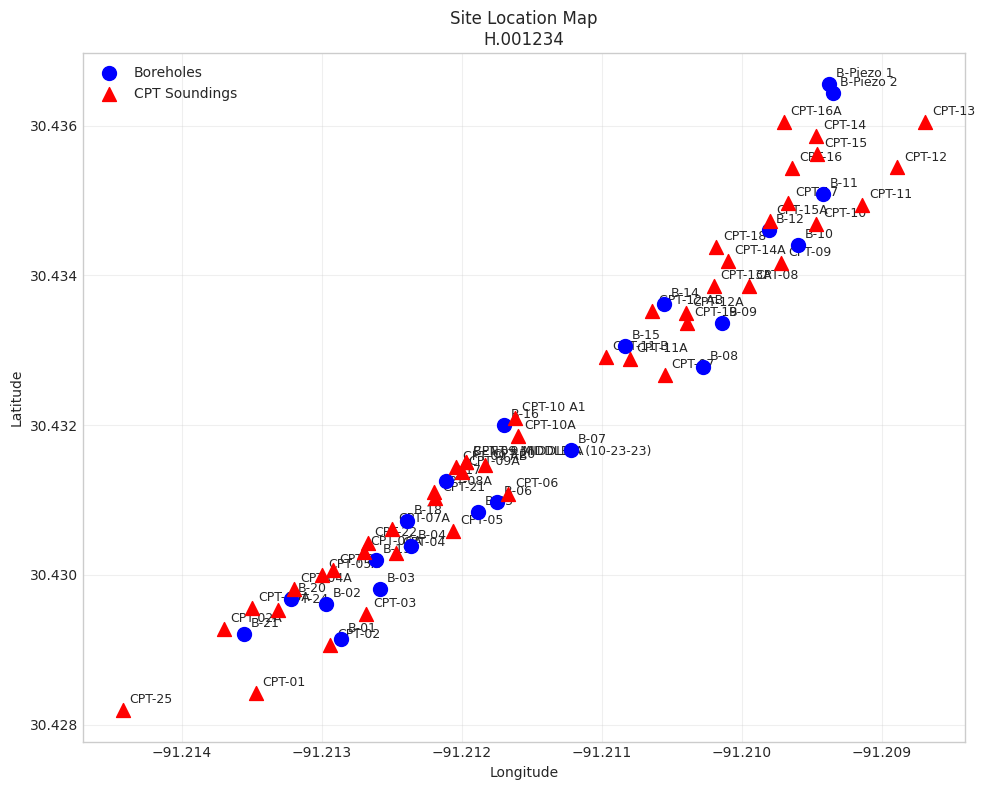

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot boreholes
if len(boreholes_df) > 0:
    ax.scatter(boreholes_df['longitude'], boreholes_df['latitude'], 
               s=100, c='blue', marker='o', label='Boreholes', zorder=5)
    # Add labels
    for idx, row in boreholes_df.iterrows():
        ax.annotate(row['name'], (row['longitude'], row['latitude']),
                   xytext=(5, 5), textcoords='offset points', fontsize=9)

# Plot soundings (CPT)
if len(soundings_df) > 0:
    ax.scatter(soundings_df['longitude'], soundings_df['latitude'], 
               s=100, c='red', marker='^', label='CPT Soundings', zorder=5)
    # Add labels
    for idx, row in soundings_df.iterrows():
        ax.annotate(row['name'], (row['longitude'], row['latitude']),
                   xytext=(5, 5), textcoords='offset points', fontsize=9)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Site Location Map\n{project_name}')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 10.2 SPT N-Value vs Depth

This is a classic geotechnical plot showing how soil strength (N-value) changes with depth.

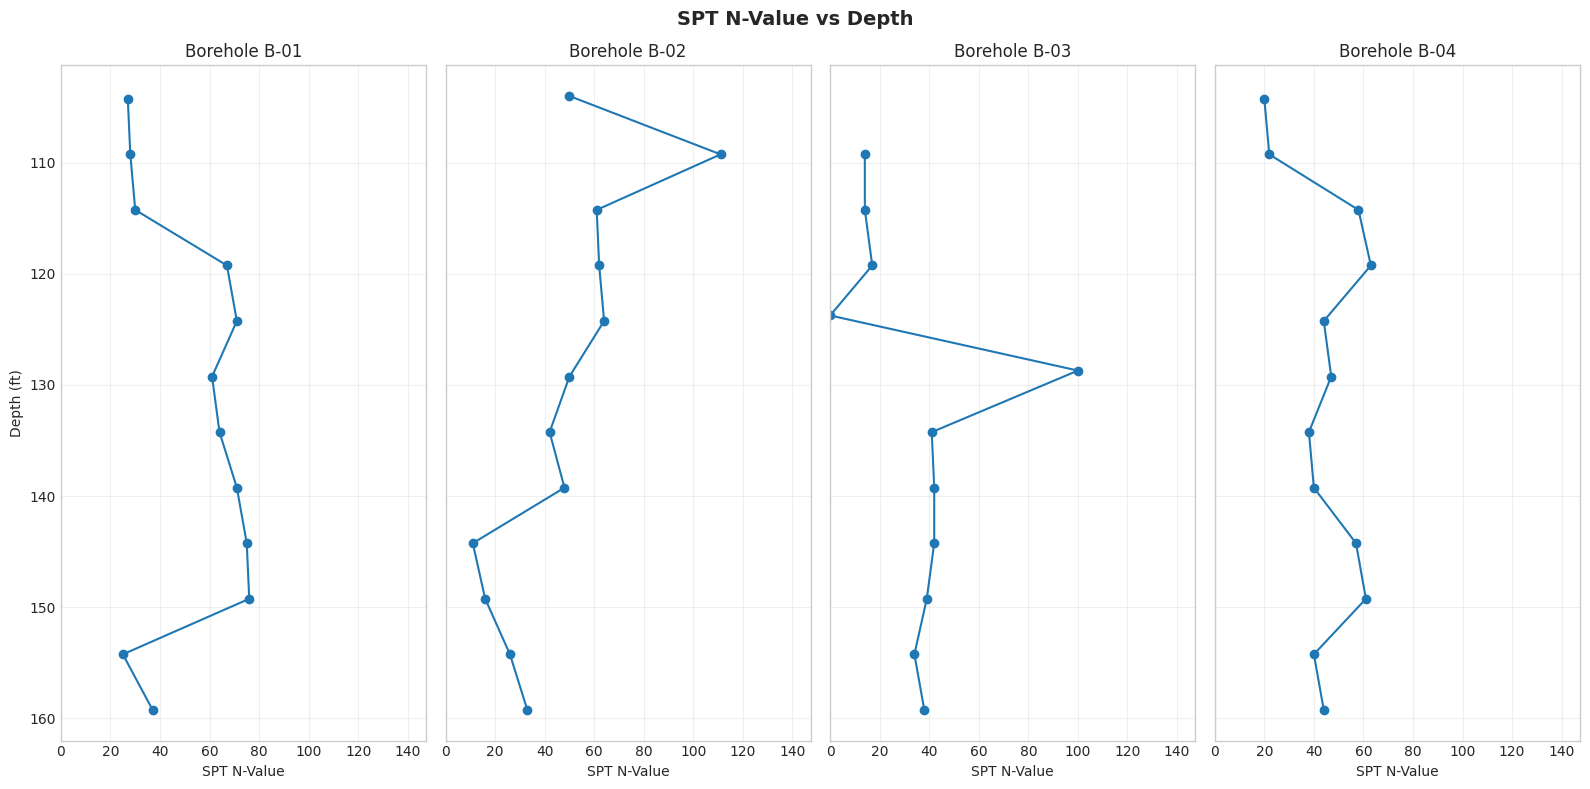

In [14]:
# Create a plot for each borehole
bh_names = spt_df['borehole'].unique()
n_plots = min(len(bh_names), 4)  # Limit to 4 plots for readability

fig, axes = plt.subplots(1, n_plots, figsize=(4*n_plots, 8), sharey=True)

if n_plots == 1:
    axes = [axes]  # Make it iterable

for idx, bh_name in enumerate(bh_names[:n_plots]):
    ax = axes[idx]
    bh_data = spt_df[spt_df['borehole'] == bh_name].copy()
    
    # Use mid-point of test depth
    bh_data['mid_depth'] = (bh_data['top_depth_ft'] + bh_data['bottom_depth_ft']) / 2
    
    # Plot N-values
    ax.plot(bh_data['n_value'], bh_data['mid_depth'], 'o-', 
            markersize=6, linewidth=1.5)
    
    ax.set_xlabel('SPT N-Value')
    ax.set_title(f'Borehole {bh_name}')
    ax.set_xlim(0, max(spt_df['n_value'].max() * 1.1, 50))
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel('Depth (ft)')
axes[0].invert_yaxis()  # Depth increases downward

fig.suptitle('SPT N-Value vs Depth', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 10.3 Data Overview Chart

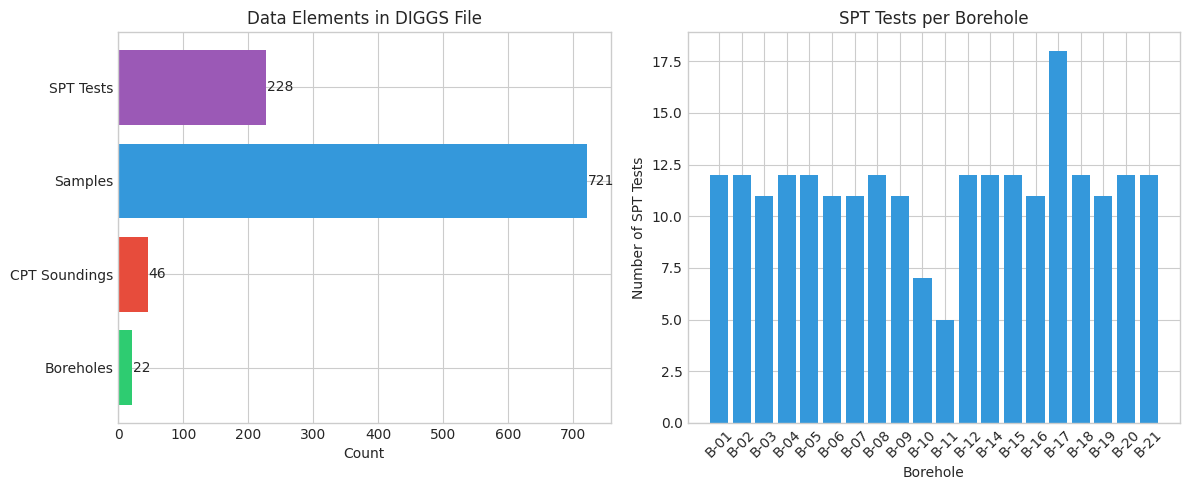

In [15]:
# Create a bar chart showing counts of different data types
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Data counts
categories = ['Boreholes', 'CPT Soundings', 'Samples', 'SPT Tests']
counts = [len(boreholes_df), len(soundings_df), len(sampling_activities), len(spt_df)]
colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6']

axes[0].barh(categories, counts, color=colors)
axes[0].set_xlabel('Count')
axes[0].set_title('Data Elements in DIGGS File')
for i, v in enumerate(counts):
    axes[0].text(v + 1, i, str(v), va='center')

# Right: SPT tests per borehole
spt_counts = spt_df.groupby('borehole').size()
axes[1].bar(spt_counts.index, spt_counts.values, color='#3498db')
axes[1].set_xlabel('Borehole')
axes[1].set_ylabel('Number of SPT Tests')
axes[1].set_title('SPT Tests per Borehole')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 11. Next Steps

Congratulations! You've learned the fundamentals of parsing DIGGS files. Here are some ideas for extending this work:

### For the Hackathon:
1. **Data Conversion**: Export DIGGS data to CSV, Excel, or other formats
2. **Visualization**: Create interactive maps or 3D subsurface models
3. **Analysis**: Calculate engineering properties from test data
4. **Validation**: Build tools to check DIGGS file compliance
5. **Integration**: Connect DIGGS with GIS or BIM systems

### Helpful Resources:
- [DIGGS Official Documentation](https://diggsml.org/docs/)
- [DIGGS GitHub Repository](https://github.com/DIGGSml)
- [DIGGS Tools & Validator](https://geosetta.org/web_map/map/DIGGS_Tools)

### Key Takeaways:
- DIGGS files are XML with multiple namespaces
- Always define your namespaces for XPath queries
- Data is organized hierarchically: Project > Boreholes/Soundings > Samples > Tests
- Use pandas DataFrames to organize extracted data for analysis

Happy coding!